In [54]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd



In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


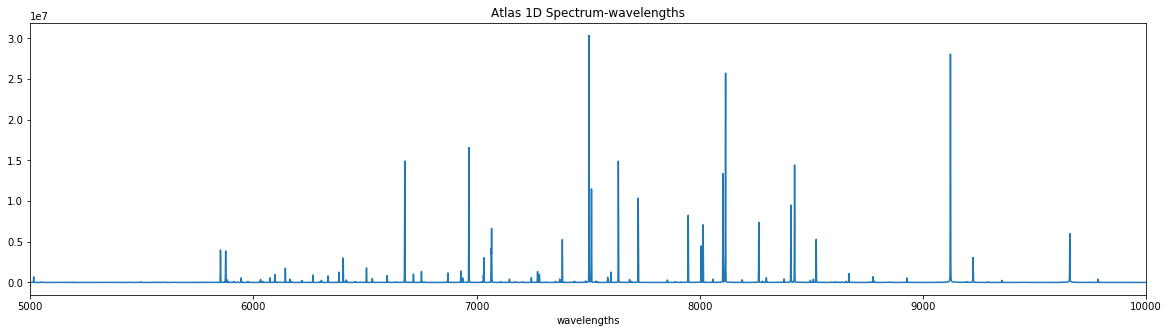

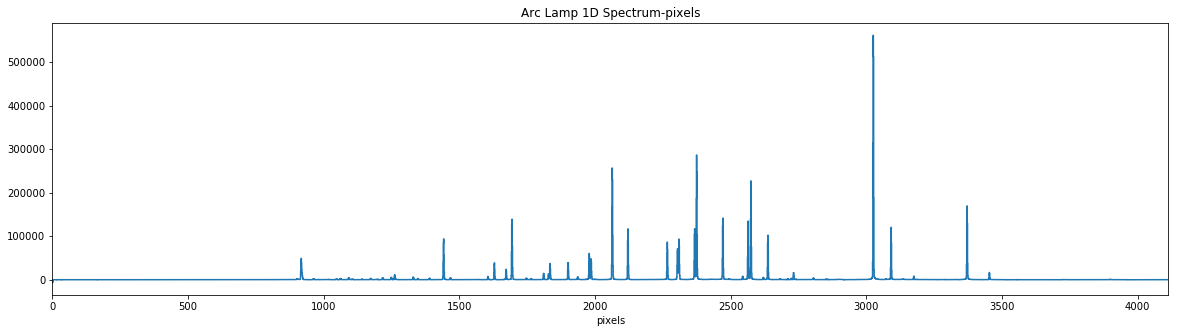

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

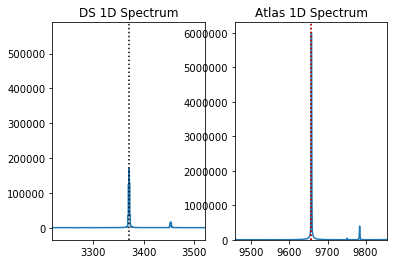

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Tried to find peak at 2095.7102377360125 but it's in a valley, not a peak"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 0.9487211223641862, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 1.1041302787798228, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.1153847553894787, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Tried to find peak at 2243.4658680624693 but it's in a valley, not a peak"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 6.71869024521498, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 7.395561544387761, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2338.0234170166977 but it's in a v

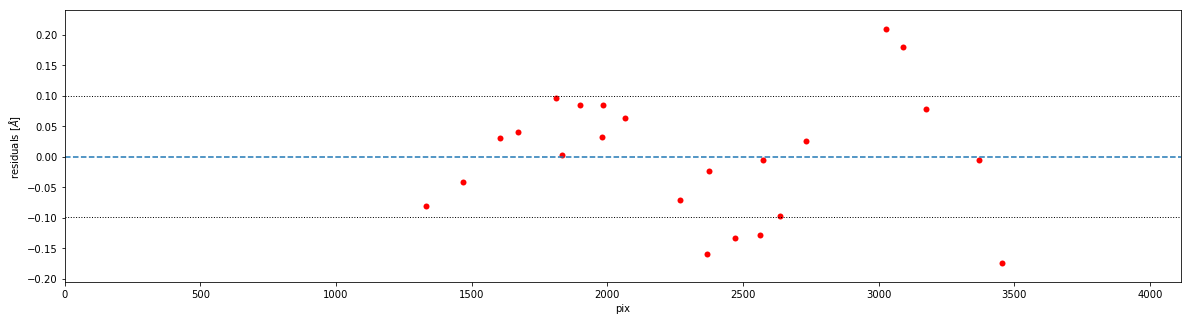

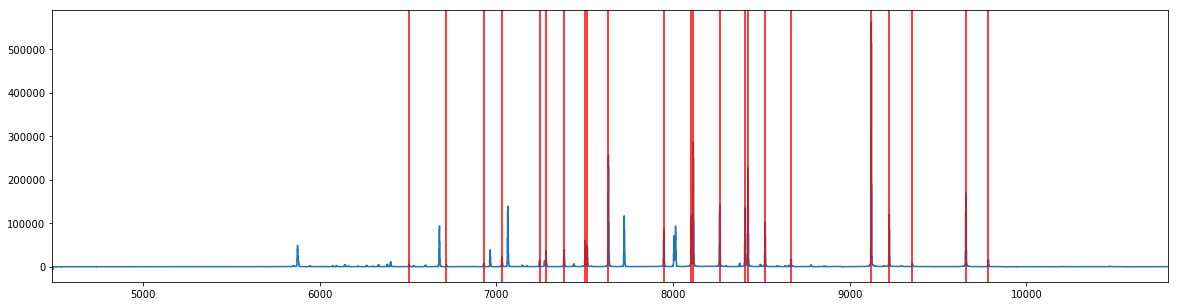

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

## SANITY CHECK

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


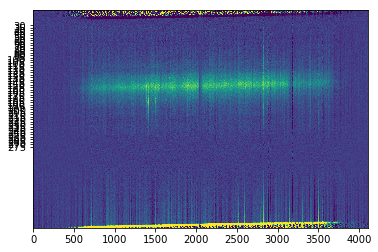

In [8]:
# SANITY CHECK

#first: want to see this newly cleaned 2d data visually
mydata=subimg2.data
vmin=-10
vmax=45
#plt.figure(figsize=(25,20)) ##REMOVE THIS LINES # TO SEE GRAPH USEFULNESS!!!!!!!!!!!!!!!!!!!!!!!!!

#instead of show_image function at top, doing this to estimate spatial row limits of H-alpha emission 
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(30,280,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

#second: now want to see newly cleaned data in numbers
print(subimg2.data[::][0])

# Extracting 2D target spectrum (reducing spatial parameters)

## ASK ERIK
### This 10 pix cut is weird....if I add 35 (target ap) does that include the 10?
### Or does it act like another cut so I should be adding 45???
### Confusing b/c flux_data is len226, same as range of target aperature, 
### so was the 10 ever really cut from flux? or only cut from wl?

FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


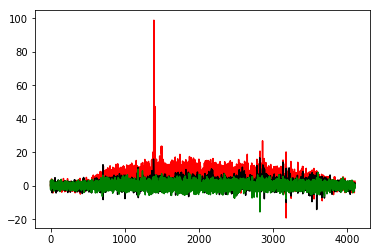

In [9]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

## SANITY CHECK - BAD

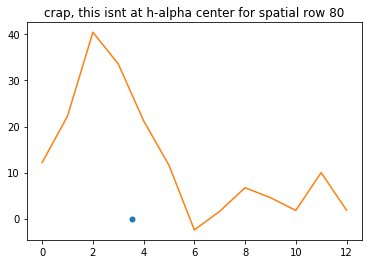

In [10]:
#good
#centroid testing in halpha reduced wl range....no ds applied

#cutting flux array to see wl's around H-alpha
flux_data_short2 = flux_data[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 80 #change which spatial row visualizing here

#doing centroid testing on individual rows to see if centroid = halpha center 
testha = flux_data_short2[row] #specifying one row to test h-alpha centroid
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array for next line
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input

#plotting results
plt.plot(x,y,'.',markersize=10)
plt.plot(testha);
plt.title('crap, this isnt at h-alpha center for spatial row {:}'.format(row))
#print(np.shape(testnewha)) #confirms made into fake 2d array
#print(testnewha[0])

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


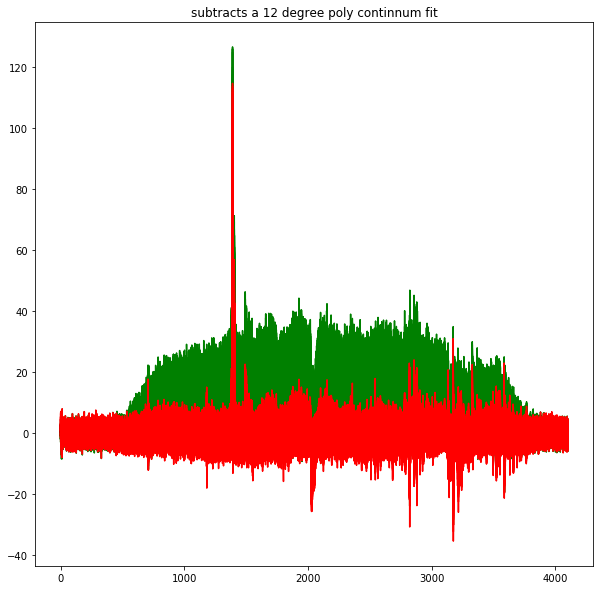

In [11]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,10))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')


## REPEATED BAD SANITY CHECK- good now

new blue dot 2.41862680072 0.0
old blue dot 3.7462368393 0.0
This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason 


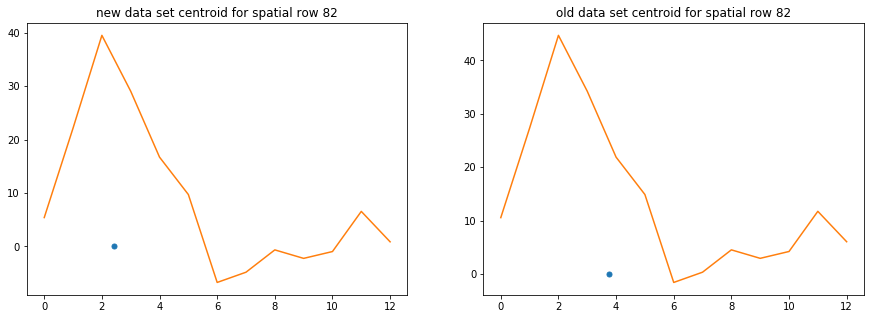

In [12]:
#new data centroiding

new_short = new[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 82 #change spatial row viewing here
#62, 27, 222 bad
#82, 122, 182 good


#new continum subt data
new_testha = new_short[row]
new_testha2 = new_testha[np.newaxis,:]
x2,y2 = centroid_com(new_testha2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(x2,y2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid for spatial row {:}'.format(row))


#original data from above bad sanity check just replotting for comparison here
testha = flux_data_short2[row] #gets weird near end of range 0-226
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array 
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input
ax2.plot(x,y,'.',markersize=10)
ax2.plot(testha);
ax2.set_title('old data set centroid for spatial row {:}'.format(row))
print('new blue dot',x2,y2)
print('old blue dot',x,y)
print('This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason ')

# Getting Galaxy Core to Center Rot. Curve around

## First Making 1D Spectrum

In [13]:
#no time to figure out why this aperture gives errors when doing the uncertaining within the function
side = 'red'
subtracted_2d = flux_data #(226,4104)
aperture = (1,225)
#extract_spectrum(side, subtracted_2d, aperture)

shape (226, 1)
x: 0.0 y: 117.150852463 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 162.150852463
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


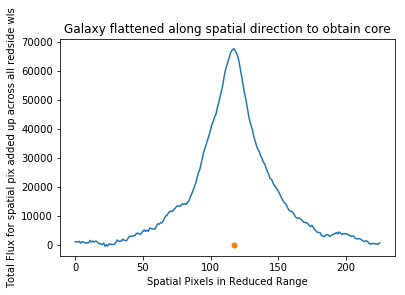

In [14]:
#hack way of doing above without a nice function

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(y_galcore, x_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = y_galcore + space_pix_correction +10 #(adds 35 to correct from target extraction),(10 from oscills subtrated from flux_data)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

# Applying DS --pix to wl associations for velocity axis (spectral) 

In [56]:
#good
#applying ds to get wl-pix associations

#first use original data to get correct wl/pix ranges to correct for cuts above
print('verifying ccd plate/original data len',len(subimg2.data[::][0])) #original 2D data


#applying DS

#wl to pix association
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))

#pix to wl association
px = []
for i in wl:
    i = int(i)
    pix = ds_red10.wltopix(i)
    px.append(pix)
px = np.array(px)


#checking ds gave 1-1 px-wl associations
print('wl:',wl)
print('px:',px)
print('px len:',len(px))
print('wl len:',len(wl))

#make this a table to carry around associations
index = np.arange(0,len(wl))
dst = Table([index, wl, px], names=('index', 'wl', 'px'))
dst #table of conversions between wl & pix plus an index to call indiv rows from table easily

verifying ccd plate/original data len 4114
wl: [  4488.43143529   4489.93082177   4491.43024058 ...,  10800.94217958
  10802.48352352  10804.02485553]
px: [ -2.87745211e-01   3.79200774e-01   1.71306397e+00 ...,   4.11038873e+03
   4.11168630e+03   4.11298387e+03]
px len: 4114
wl len: 4114


index,wl,px
int64,float64,float64
0,4488.43143529,-0.287745211148
1,4489.93082177,0.379200773968
2,4491.43024058,1.71306397431
3,4492.9296917,2.37998119461
4,4494.42917511,3.71378688821
5,4495.92869082,4.38067536659
6,4497.42823881,5.7144235992
7,4498.92781907,6.38128335852
8,4500.42743158,7.71497417587


In [16]:
#can prolly delete, did after centroiding
#Do THIS AFTER CENTROIDING!!!

#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!

r_in_arcmin = 1*u.arcmin# radial distance from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)

r_in_arcmin

<Quantity 0.009766666666666667 arcmin>

# H-alpha Centroids for Entire Target

2.65424669078 0.0
6.97941991949 0.0
2.06471857268 0.0
-1.86151621669 0.0
1.8358527898 0.0
1.11596279001 0.0
-0.618471784562 0.0
2.80268275936 0.0
-0.754606279047 0.0
0.897057038498 0.0
0.124417618478 0.0
1.79919080797 0.0
1.89199362023 0.0
1.1117248856 0.0
0.691238709606 0.0
1.01327889875 0.0
-0.839770324828 0.0
1.58811547395 0.0
1.64560125499 0.0
1.0352266697 0.0
0.232809764919 0.0
-0.322423560171 0.0
-0.0428209354201 0.0
-4.57331279846 0.0
1.39303776899 0.0
-0.878554026822 0.0
3.23060730535 0.0
-36.4445175083 0.0
-4.22123400352 0.0
-1.20775339047 0.0
-0.317330148647 0.0
3.05199771944 0.0
-6.31634980604 0.0
-4.20241009193 0.0
1.28746476846 0.0
1.60343184082 0.0
0.347166421068 0.0
0.0881512003352 0.0
0.905504300519 0.0
0.956370748679 0.0
1.76826252973 0.0
1.53804741037 0.0
2.24208655548 0.0
2.51158610683 0.0
0.528864536244 0.0
1.90596775953 0.0
-0.79543972653 0.0
-0.0500598021986 0.0
-1.40174495035 0.0
1.5291232896 0.0
1.62345860182 0.0
1.90940675314 0.0
0.766255122341 0.0
0.2662736894

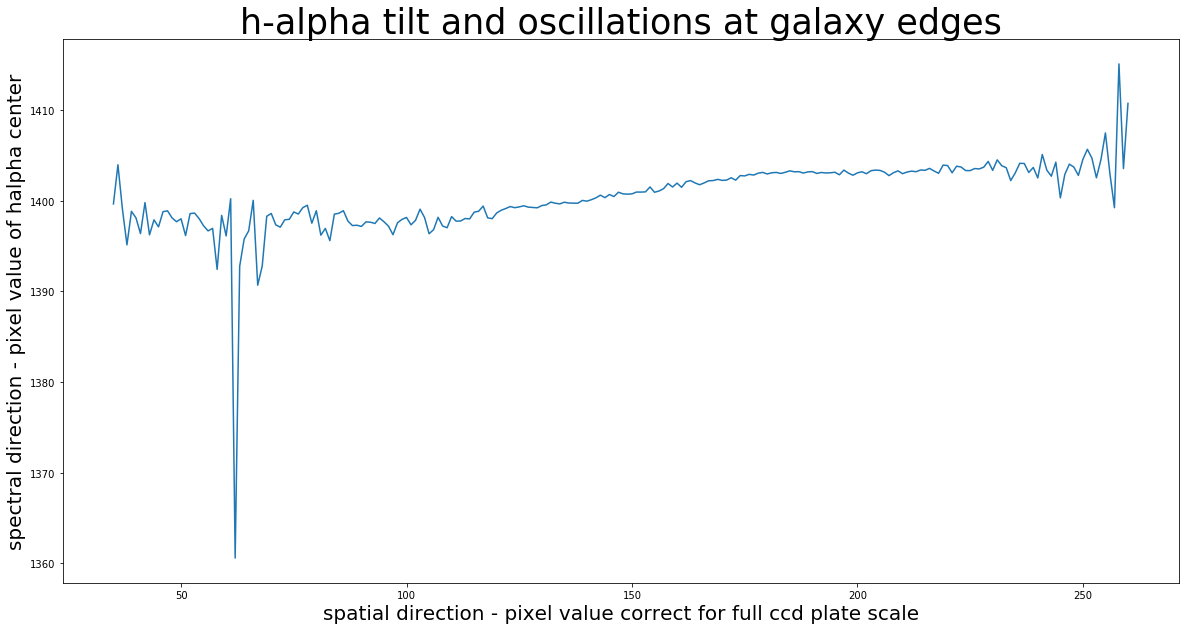

In [17]:
#good
#gets h-alpha centroid values for every spatial row within the target range 

#below for reference, uses full ccd wl range - first defined when applied DS
#wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1387:1400] #isolate wl around h-alpha using full ccd plate wl range



mylist2 = []
mylist_ys2 = []
holding2 = []
ha_wls2 = []
##below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#concerned 10 wl cut means 10 flux cut too in the lenght of the data but cant decide
#if the 10 is already accounted for by +1387 or should also add into space_pix_correction2
#b/c that 10 cut cutout those wl's and corresponding fluxes
##new_short = new[:,1387:1400] #cut to isolate wl around h-alpha

#gets halpha centroids in target gal's range
for row in new_short:
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist4, mylist5 = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    print(mylist4, mylist5)
    holding_arr2 = row, wl_shorter2
    x = np.array([row,wl_shorter2])
    mylist_ys2.append(mylist5)
    mylist2.append(mylist4) #collects all halpha centers per row
mylist2=np.array(mylist2) #halpha centroids (wl) array

#correction for target wl pix's to match index of full ccd plate pix's (still not correct len but dont care about below target pixs-no data there neway)
wl_pix_corrected = mylist2 + wl_pix_correction + 1387 #decide how to better automate/track this
print('wl_pix_corrected defined here')
#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
space_pix_correction2 = np.arange(len(mylist2)) + space_pix_correction

print('len',len(mylist2),type(mylist2), np.shape(mylist2))
print('len',len(space_pix_correction2),type(space_pix_correction2), np.shape(space_pix_correction2))


print('double check corrections after decide how to deal with 10 pix cut from around ln[8]')
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(space_pix_correction2,wl_pix_corrected)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha tilt and oscillations at galaxy edges',fontsize=35)
#plt.ylim(-1,10)

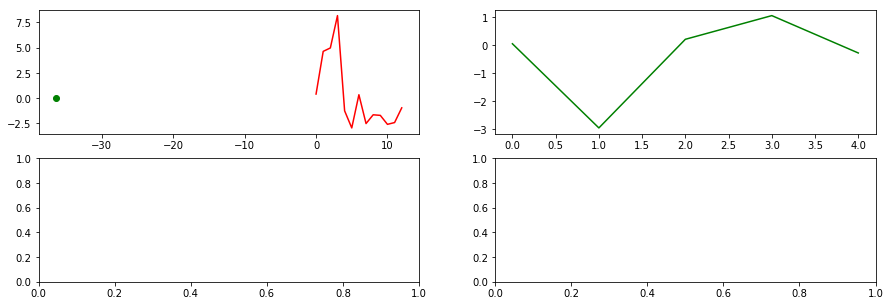

In [18]:
#testing why some values in mylist2 (ha centroids) are negative
a = new_short[27]
d = new[25:30,1414]
luna = ([new_short[27]]) #makes array into a list



b = a[np.newaxis, :]
x,y = centroid_com(b)
f, ((ax1, ax2),(ax3)) = plt.subplots(2,2,figsize=(15,5))
ax1.plot(x,y, 'o',color='g')
ax1.plot(a, color='r')
ax2.plot(d, color='g')

#ax3.plot(luna) #refuses to see it as anything but an array idk why oh well
#plt.plot(mylist2[27], color='g')

0.402965345329
4.62764724629
4.96407189261
8.16459284116
-1.25799231331
-2.94945307419
0.336117574442
-2.51757666468
-1.6485476814
-1.70724360625
-2.59470291377
-2.41753132892
-0.961253508803


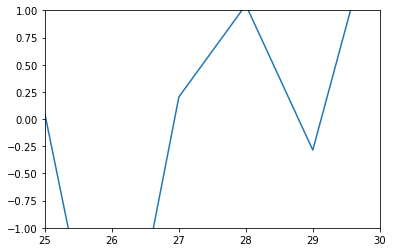

In [19]:
#trying to see this is full dataset (not ha isolated wl range)
d = new[:,1414]
plt.plot(d)
plt.xlim(25,30)
plt.ylim(-1,1)
for i in new_short[27]:
    print(i)

In [20]:
print('pretend mylist2 negative values are ok....pretty sure its just due to inadequate flux')

pretend mylist2 negative values are ok....pretty sure its just due to inadequate flux


In [21]:
np.arange(len(mylist2)) #0-225 array
space_pix_correction #35
space_pix_correction2 #35-260 array #pix value of spatial row in target range corrected wrt entire ccd plate size
spatial_core_pix #152.150....+10 added when defined so now its 162.15.....
space_pix_correction2

array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 21

# Converting Pixels --> kpc 

## ASK if core centering subtraction done on distance axis or velocity axis


In [22]:
#centering  around core......chose on distance axis for now

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#space_pix_correction2 is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale


distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix

#print('space',space_pix_correction2)
#print('location', location_pix)

In [23]:
#maybe delete
''' 
arcmins = []

for i in space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity
    #r_in_arcmin.append(arcmins)
    #arcmins.append(r_in_arcmin)
#armins = np.array(arcmins)
#print(arcmins)
'''

" \narcmins = []\n\nfor i in space_pix_correction2:\n    r_in_arcmin = 1*u.arcmin\n    redplatescale = 0.293*u.arcsec/u.pixel\n    dbsp_pix_equiv = u.pixel_scale(redplatescale)\n    r_in_pixel = i*u.pixel\n    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)\n    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity\n    #r_in_arcmin.append(arcmins)\n    #arcmins.append(r_in_arcmin)\n#armins = np.array(arcmins)\n#print(arcmins)\n"

In [24]:
#maybe delete
''' 
distance = 37*u.Mpc # distance of object from us
another =[]
for i in armins:
    r_in_kpc = (i/u.rad*distance).to("kpc")
    another.append(r_in_kpc)
another = np.array(another)
another'''

' \ndistance = 37*u.Mpc # distance of object from us\nanother =[]\nfor i in armins:\n    r_in_kpc = (i/u.rad*distance).to("kpc")\n    another.append(r_in_kpc)\nanother = np.array(another)\nanother'

In [25]:
#good
#converts pixels to kpc (distance profile)
arcmins = []
another =[]
more = []

#below for reference
#distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore:#space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin))
    distance = 37*u.Mpc # distance of object from us
    r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc")
    #print(r_in_kpc)
    ##more = [r_in_kpc]
    more = r_in_kpc
    another.append(more)
#another = np.array(another)
another

    

[<Quantity -6.682877300479059 kpc>,
 <Quantity -6.630318649309975 kpc>,
 <Quantity -6.5777599981408885 kpc>,
 <Quantity -6.525201346971806 kpc>,
 <Quantity -6.472642695802718 kpc>,
 <Quantity -6.420084044633636 kpc>,
 <Quantity -6.36752539346455 kpc>,
 <Quantity -6.314966742295465 kpc>,
 <Quantity -6.26240809112638 kpc>,
 <Quantity -6.209849439957296 kpc>,
 <Quantity -6.157290788788212 kpc>,
 <Quantity -6.104732137619127 kpc>,
 <Quantity -6.052173486450042 kpc>,
 <Quantity -5.999614835280957 kpc>,
 <Quantity -5.947056184111872 kpc>,
 <Quantity -5.894497532942786 kpc>,
 <Quantity -5.841938881773702 kpc>,
 <Quantity -5.7893802306046185 kpc>,
 <Quantity -5.736821579435533 kpc>,
 <Quantity -5.684262928266448 kpc>,
 <Quantity -5.631704277097363 kpc>,
 <Quantity -5.579145625928278 kpc>,
 <Quantity -5.526586974759193 kpc>,
 <Quantity -5.47402832359011 kpc>,
 <Quantity -5.421469672421025 kpc>,
 <Quantity -5.3689110212519395 kpc>,
 <Quantity -5.316352370082854 kpc>,
 <Quantity -5.26379371891377

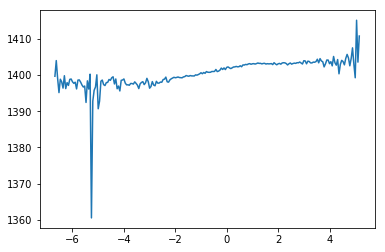

In [26]:
#good 
#demonstrating a BETTER WAY to plot quantity arrays thats easier than what i did above and below to get it to plot
plt.plot(u.Quantity(another), wl_pix_corrected)

(1395, 1410)

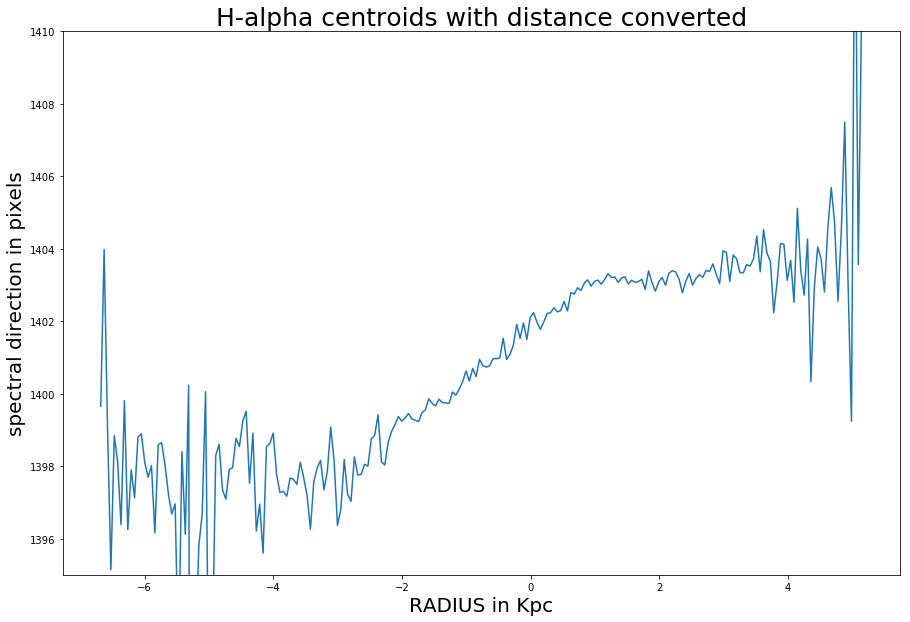

In [27]:
from astropy.visualization import quantity_support
quantity_support() 

from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(another * u.kpc,wl_pix_corrected)
plt.title('H-alpha centroids with distance converted',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1395,1410)

In [28]:
irange = np.arange(len(wl_pix_corrected))
table= Table([irange, wl_pix_corrected,u.Quantity(another)], names=('index','wl','kpc'))
table2=table[np.where(table['kpc']==0.0)]
table2
print('zero centered core problem b/c radius data never exactly =0 ')
#for i in table:
#    print(i)
table[127:129]

zero centered core problem b/c radius data never exactly =0 


index,wl,kpc
,,kpc
int64,float64,float64
127,1402.10913391,-0.00792860200529
128,1402.23211977,0.0446300491638


# Converting wl to velocity

In [29]:
#trys to match centroid array to ds table with wl/pix associations- but diff lengths problems


#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale


#making centroid array same length to add to dst, need to add zeros to slots above & below target range
begin = np.arange(0,1387)
#print(len(begin))
#end = np.arange()

#n/m try new method of cutting table instead?
#dst2['ha centroids']= 

#need to get these pixs into wl via ds
wl_pix_corrected # pixel value of ha centroids

#problem with below is lengths of table and array dont match
#dst['ha centroids pix']= wl_pix_corrected
#dst

print('test start',wl_pix_corrected[0])
print('test end',wl_pix_corrected[-1])
end = int(wl_pix_corrected[-1]) + 2 #added 2 so px table column included  ha centroids pix range
print('end',end)
#first need to cut dst table so length matches lenght of list of ha centroid pix values
##low = np.where(dst['index'] == int(wl_pix_corrected[0]))#trying np where to connect table row index to lowest ha centroid wl
##print('low',low)
start = int(wl_pix_corrected[0])
print('start',start)
dst2 = dst[start:end]

print('could try an interpolation?? to get a "real" wl value for each centroid pix')
dst2

test start 1399.65424669
test end 1410.75717138
end 1412
start 1399
could try an interpolation?? to get a "real" wl value for each centroid pix


index,wl,px
int64,float64,float64
1399,6612.78036907,1398.49130742
1400,6614.31445021,1399.79502466
1401,6615.84854863,1400.4468761
1402,6617.38266429,1401.75056465
1403,6618.91679721,1402.40240176
1404,6620.45094735,1403.70606165
1405,6621.98511472,1404.35788444
1406,6623.51929931,1405.66151571
1407,6625.05350109,1406.96512792


In [30]:
#the index of the centroid array should match the index in the table array tho

anarray = np.arange(35,len(wl_pix_corrected)+1,1)
#print(anarray)
for i in anarray:
    a = np.where(dst['index'] == i)
    a
    dst3=dst[a]
dst3

index,wl,px
int64,float64,float64
226,4828.09414559,225.937503002


In [31]:
wl_pix_corrected

array([ 1399.65424669,  1403.97941992,  1399.06471857,  1395.13848378,
        1398.83585279,  1398.11596279,  1396.38152822,  1399.80268276,
        1396.24539372,  1397.89705704,  1397.12441762,  1398.79919081,
        1398.89199362,  1398.11172489,  1397.69123871,  1398.0132789 ,
        1396.16022968,  1398.58811547,  1398.64560125,  1398.03522667,
        1397.23280976,  1396.67757644,  1396.95717906,  1392.4266872 ,
        1398.39303777,  1396.12144597,  1400.23060731,  1360.55548249,
        1392.778766  ,  1395.79224661,  1396.68266985,  1400.05199772,
        1390.68365019,  1392.79758991,  1398.28746477,  1398.60343184,
        1397.34716642,  1397.0881512 ,  1397.9055043 ,  1397.95637075,
        1398.76826253,  1398.53804741,  1399.24208656,  1399.51158611,
        1397.52886454,  1398.90596776,  1396.20456027,  1396.9499402 ,
        1395.59825505,  1398.52912329,  1398.6234586 ,  1398.90940675,
        1397.76625512,  1397.26627369,  1397.30368844,  1397.16911014,
      

In [32]:
#trying interpolation
from scipy.interpolate import interp1d
ds_pixels = dst3['px']
centroid_pixels = wl_pix_corrected
#below wont work b/c not same length
#f = interp1d(ds_pixels, centroid_pixels)


# Ask about hubble constant value below

In [33]:
#good
#need host z

#calculating z of host
#distance = (c*z)/hubbleconst so need --> (dist * h0) / c = z
distance = 37*u.Mpc #host dist from saga paper
H0 = 70 * u.km / u.s / u.Mpc #hubble const
c = const.c.to('km/s') #speed of light
host_z = (distance * H0)/ c
print('Catch22-host redshift:',host_z)

Catch22-host redshift: 0.00863931006563214


In [34]:
np.shape(wl_pix_corrected)
c

<Quantity 299792.458 km / s>

core row 162
core wl pix value: 1403.38919389


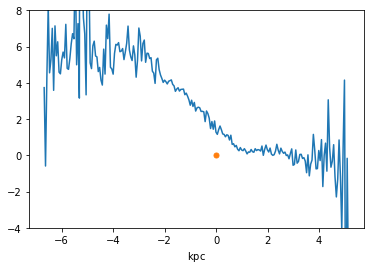

In [35]:
#PROBLEMS

#where is h-alpha centroid (wl) for spatial core row--thats core on wl side 
spatial_rowof_core = int(spatial_core_pix) #pixel value of spatial row defined as galaxy core based on 1d spec centroid
print('core row', spatial_rowof_core)
core_wl = wl_pix_corrected[spatial_rowof_core] #getting centroid wl pixel at the spatial core
print('core wl pix value:',core_wl)
#velocity = hubbleconst * distance


#making core velocity=0
relative_tocore_pix = core_wl - wl_pix_corrected

#sanity check
plt.plot(u.Quantity(another), relative_tocore_pix)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-4,8) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

In [36]:
wl_pix_corrected

array([ 1399.65424669,  1403.97941992,  1399.06471857,  1395.13848378,
        1398.83585279,  1398.11596279,  1396.38152822,  1399.80268276,
        1396.24539372,  1397.89705704,  1397.12441762,  1398.79919081,
        1398.89199362,  1398.11172489,  1397.69123871,  1398.0132789 ,
        1396.16022968,  1398.58811547,  1398.64560125,  1398.03522667,
        1397.23280976,  1396.67757644,  1396.95717906,  1392.4266872 ,
        1398.39303777,  1396.12144597,  1400.23060731,  1360.55548249,
        1392.778766  ,  1395.79224661,  1396.68266985,  1400.05199772,
        1390.68365019,  1392.79758991,  1398.28746477,  1398.60343184,
        1397.34716642,  1397.0881512 ,  1397.9055043 ,  1397.95637075,
        1398.76826253,  1398.53804741,  1399.24208656,  1399.51158611,
        1397.52886454,  1398.90596776,  1396.20456027,  1396.9499402 ,
        1395.59825505,  1398.52912329,  1398.6234586 ,  1398.90940675,
        1397.76625512,  1397.26627369,  1397.30368844,  1397.16911014,
      

acore 127
core wl pix value: 1402.10913391


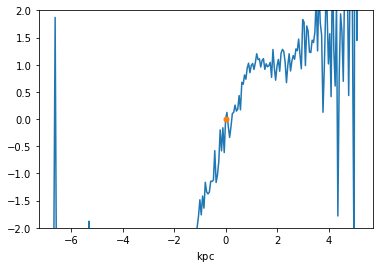

In [37]:
#good
#2nd attempt at above 
acore = int(spatial_core_pix) - 35 #to get acct for target spactial range cut when getting correct core index
print('acore',acore)
core_wl = wl_pix_corrected[acore]
print('core wl pix value:',core_wl)



#making core velocity=0
#relative_tocore_pix = core_wl - wl_pix_corrected #reverse this ie subtract core_wl
relative_tocore_pix = wl_pix_corrected - core_wl# rename as wl_pixshift_wrtcore

#sanity check
plt.plot(u.Quantity(another), relative_tocore_pix)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-2,2) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

In [38]:
relative_tocore_pix
#core_wl
#wl_pixshift_wrtcore

array([ -2.45488722,   1.87028601,  -3.04441533,  -6.97065012,
        -3.27328112,  -3.99317112,  -5.72760569,  -2.30645115,
        -5.86374019,  -4.21207687,  -4.98471629,  -3.3099431 ,
        -3.21714029,  -3.99740902,  -4.4178952 ,  -4.09585501,
        -5.94890423,  -3.52101843,  -3.46353265,  -4.07390724,
        -4.87632414,  -5.43155747,  -5.15195484,  -9.68244671,
        -3.71609614,  -5.98768793,  -1.8785266 , -41.55365142,
        -9.33036791,  -6.3168873 ,  -5.42646406,  -2.05713619,
       -11.42548371,  -9.311544  ,  -3.82166914,  -3.50570207,
        -4.76196749,  -5.02098271,  -4.20362961,  -4.15276316,
        -3.34087138,  -3.5710865 ,  -2.86704735,  -2.5975478 ,
        -4.58026937,  -3.20316615,  -5.90457363,  -5.15919371,
        -6.51087886,  -3.58001062,  -3.48567531,  -3.19972715,
        -4.34287879,  -4.84286022,  -4.80544547,  -4.94002377,
        -4.43781559,  -4.47249044,  -4.61237492,  -4.00288406,
        -4.42454839,  -4.90633681,  -5.85261744,  -4.53

In [39]:
print('one',len(wl_pix_corrected))
#print('two',len(spatial_core_pix))
spatial_core_pix
##########relative_tocore_wl


one 226


162.1508524634657

In [40]:
#making pixel spread into velocities
#velocity = (relative_tocore_pix * c) / host_z

#doppler shift formula...made rest_wl=0 via core centering(=0)
#shift = rest_wl * (velocity/c) so use --> (shift * c)/core_wl_pix
##velocity = (relative_tocore_pix/core_wl) * c #not much diff betwn one sent to erik&laura
###velocity = (relative_tocore_pix * c) / core_wl #sent this one to erik&laura
#core_wl is the ha centroid wl_pix value at the galaxy core
#velocity = (relative_tocore_pix/acore) * c #gives 1000+ km/s velocities=WRONG
#velocity = (relative_tocore_pix * c) / acore #gives 10,000s km/s velocities=WRONG
#velocity = (relative_tocore_pix  / host_z) * c #gives 10**9 km/s velocities=WRONG
velocity = (relative_tocore_pix / core_wl) * c


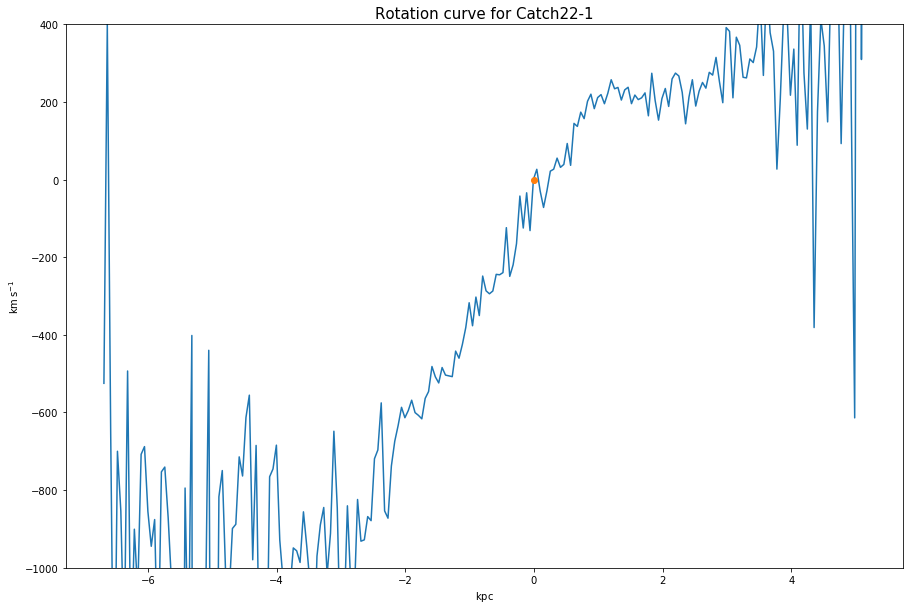

In [41]:
#sanity check
plt.figure(figsize=(15,10))
plt.plot(u.Quantity(another), u.Quantity(velocity))
plt.title('Rotation curve for Catch22-1',fontsize=15)
#plt.ylim(-300,900)
#plt.ylim(-850,400)
#plt.ylim(-1000,1000)
plt.ylim(-1000,400)

#hopefully = core_wl - wl_pix_corrected[162]#128
plt.plot(0,0,'o')
#plt.savefig('RC4C22')

In [43]:
#not sure, prolly was checking something
core_row = int(spatial_core_pix)
#print('core row',spatial_coreof_row)
core = wl_pix_corrected[162]
print('core:', core)

#below used to check values to be between 0 and 28 to be amt of shift wrt core
#for i in mylist2: #mostly they were but problem b/c some negatives
#    print(int(i)) #negatives likely due to bad flux collection on ccd/bad pixels

core: 1403.38919389


In [58]:
#trying to get space pixels and centroid wl pixels into one array


#below b/c want centroid-wl data to match in size to original data (b/c distance axis needs it)
#np.shape(subimg2.data)#(440,4114)
top_CCD = np.zeros(35,)
top_CCD
bottom_CCD = np.zeros(179,)
bottom_CCD
merged_data = np.concatenate((top_CCD, wl_pix_corrected, bottom_CCD)) #array for full CCD size (space indices), 
#with centroid wl values in correct target location-spatial&wl axes
index2 = np.arange(0,len(wl_pix_corrected),1)
centroids_table = Table([index2, wl_pix_corrected, space_pix_correction2], names=('indices help','wl pix','spatial pix'))
centroids_table

indices help,wl pix,spatial pix
int64,float64,int64
0,1399.65424669,35
1,1403.97941992,36
2,1399.06471857,37
3,1395.13848378,38
4,1398.83585279,39
5,1398.11596279,40
6,1396.38152822,41
7,1399.80268276,42
8,1396.24539372,43


In [59]:
#checking data values unchanged--good
np.shape(wl_pix_corrected)# (226,)
np.shape(space_pix_correction2) #(226,)

(226,)

In [60]:
#checking what i want happened
np.shape(merged_data) #440,
merged_data[35] #begining of centroid wl data array
print('good this is what i wanted now ready to add to table')

good this is what i wanted now ready to add to table


In [61]:
np.shape(dst) #(4114,)
dst #disperson soln table

index,wl,px
int64,float64,float64
0,4488.43143529,-0.287745211148
1,4489.93082177,0.379200773968
2,4491.43024058,1.71306397431
3,4492.9296917,2.37998119461
4,4494.42917511,3.71378688821
5,4495.92869082,4.38067536659
6,4497.42823881,5.7144235992
7,4498.92781907,6.38128335852
8,4500.42743158,7.71497417587


In [70]:
#want to match centroids_table and dst via columns wl pix/wl


#need to convert to pandas to do that tho
centroids_pandas = pd.DataFrame({'indices_help':index2,'wl_pix':wl_pix_corrected,'spatial_pix': space_pix_correction2})
dst_pandas = pd.DataFrame({'index':index,'wl': wl,'px': px})

#combines above tables
merged = centroids_pandas.merge(dst_pandas, left_on="wl_pix", right_on="wl", how="right", suffixes=("_centroids", "_dst"))
merged

,indices help,spatial pix,wl_pix,index,px,wl
0,NaN,NaN,NaN,0,-0.287745,4488.431435
1,NaN,NaN,NaN,1,0.379201,4489.930822
2,NaN,NaN,NaN,2,1.713064,4491.430241
3,NaN,NaN,NaN,3,2.379981,4492.929692
4,NaN,NaN,NaN,4,3.713787,4494.429175
5,NaN,NaN,NaN,5,4.380675,4495.928691
6,NaN,NaN,NaN,6,5.714424,4497.428239
7,NaN,NaN,NaN,7,6.381283,4498.927819
8,NaN,NaN,NaN,8,7.714974,4500.427432
9,NaN,NaN,NaN,9,8.381805,4501.927076


In [75]:
#chopping table to relevant wl range where combos happen

only_in_centroids = merged.loc[merged.px.isnull()]
only_in_centroids


,indices help,spatial pix,wl_pix,index,px,wl


In [50]:
#eventually will get to this




#applying DS via hack

#hack needed b/c cant apply ds unless data's a dbl spec object class, and its not 
#hack is making centroid/distance/inpixels array match the ds table made way above to pull out pix-wl correlations

